# Post-processing N-body snapshots with BEoRN


In [20]:
import numpy as np

In [21]:
# Add the local version of the module to the path
import sys
sys.path.append('../src/')

In [22]:
from beorn import run
from beorn.astro import f_star_Halo
from beorn.plotting import *
from beorn.parameters import Parameters

## Choose a source model.
For more details on parameter definitions, see [arXiv/2305.15466](https://arxiv.org/abs/2305.15466).

In [23]:
parameters = Parameters()

# # Halo Mass bins
parameters.simulation.halo_mass_bin_min = 1e7
parameters.simulation.halo_mass_bin_max = 1e15
parameters.simulation.halo_mass_bin_n = 40  # nbr of halo mass bin

# name your simulation
parameters.simulation.model_name = 'test'
# Nbr of cores to use
parameters.simulation.cores = 1  

# simulation redshifts
parameters.solver.Nz = [7.72]  

# cosmo
parameters.cosmology.Om = 0.31
parameters.cosmology.Ob = 0.045
parameters.cosmology.Ol = 0.69
parameters.cosmology.h = 0.68

# Source parameters
# lyman-alpha 
parameters.source.n_lyman_alpha_photons = 9690  # 1500
parameters.source.alS_lyal = 0.0
# ion
parameters.source.Nion = 3000  
# xray
parameters.source.E_min_xray = 500
parameters.source.E_max_xray = 10000
parameters.source.E_min_sed_xray = 200
parameters.source.E_max_sed_xray = 10000
parameters.source.alS_xray = 1.5
parameters.source.xray_normalisation = 3.4e40

# fesc
parameters.source.f0_esc = 0.2
parameters.source.pl_esc = 0.5

# fstar
parameters.source.f_st = 0.14
parameters.source.g1 = 0.49
parameters.source.g2 = -0.61
parameters.source.g3 = 4
parameters.source.g4 = -4
parameters.source.Mp = 1.6e11 * parameters.cosmology.h
parameters.source.Mt = 1e9

# Minimum star forming halo
parameters.source.halo_mass_min = 1e8

# Mass Accretion Rate model (EXP or EPS)
parameters.source.mass_accretion_model = 'EPS'

## Compute profiles (ly-al, xHII, Tk)

In [24]:
# Step 1 : profiles
run.compute_profiles(parameters)

Computing Temperature (Tk), Lyman-α and ionisation fraction (xHII) profiles...
param.solver.Nz is given as a list.
param.solver.fXh is set to constant. We will assume f_X,h = 2e-4**0.225
...  Profiles stored in dir ./profiles.
 
It took 00:01:22 to compute the profiles.


## Plot the profiles

In [25]:
profiles = beorn.load_f('./profiles/test.pkl')
plt.loglog(profiles.M_Bin, f_star_Halo(parameters,profiles.M_Bin))
plt.ylim(0.002,0.3)
plt.ylabel(r'$f_*$ = $\dot{M}_{*}/\dot{M}_{\mathrm{h}}  $', fontsize=15)
plt.xlabel('M$_*$ $[M_{\odot}]$', fontsize=15)
ind_M = 20
plot_1D_profiles(parameters, profiles, ind_M, z_liste=[13,10,8])

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_47215/2170824821.py:5: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('M$_*$ $[M_{\odot}]$', fontsize=15)


NameError: name 'beorn' is not defined

## Paint profiles on 3D grids


In [ ]:
# Box size and Number of pixels
Lbox = 100 # cMpc/h
Ncell = 128
parameters.simulation.Lbox = Lbox
parameters.simulation.Ncell = Ncell
parameters.simulation.halo_catalogs = './halo_catalog/pkdgrav_halos_z'  ## path to dir with halo catalogs + filename
parameters.simulation.dens_field =  './density_field/grid_' + str(Ncell) + '_B100_CDM.z' # None
parameters.simulation.dens_field_type = 'pkdgrav'
parameters.simulation.store_grids = ['Tk','bubbles','lyal' ,'dTb'] 

# define k bins for PS measurement
kmin = 1 / Lbox
kmax = Ncell / Lbox
kbin = int(6 * np.log10(kmax / kmin))
parameters.simulation.kmin = kmin
parameters.simulation.kmax = kmax
parameters.simulation.kbin = kbin

In [ ]:
# Step 2 : Paint Boxes and read and write GS and PS in ./physics/
run.paint_boxes(parameters, RSD=False, ion=True, temp=True, dTb=True, lyal=True, check_exists = False, cross_corr=True)

# Step 3 : gather the GS_PS files at different redshifts and create a single GS_PS.pkl file.
run.gather_GS_PS_files(parameters,remove = False)

# Option : Quick calculation of the global quantities from halo catalogs and profiles (similar to eq 11 in 2302.06626)
GS = beorn.compute_glob_qty(parameters)
beorn.save_f(file='./physics/GS_approx_' + parameters.simulation.model_name + '.pkl',obj = GS)



Painting profiles on a grid with 128 pixels per dim. Box size is 100 cMpc/h.
param.solver.Nz is given as a list.
Core nbr 0 is taking care of z =  7.72
----- Painting 3D map for z = 7.72 -------
reading pkdgrav density field....
There are 66390 halos at z= 7.715124
Looping over halo mass bins and painting profiles on 3D grid .... 
Quick calculation from the profiles predicts xHII =  0.2363
17220 halos in mass bin  16 . It took 00:00:02 to paint the profiles.
24672 halos in mass bin  17 . It took 00:00:03 to paint the profiles.
12567 halos in mass bin  18 . It took 00:00:05 to paint the profiles.
6295 halos in mass bin  19 . It took 00:00:07 to paint the profiles.
3075 halos in mass bin  20 . It took 00:00:08 to paint the profiles.
1426 halos in mass bin  21 . It took 00:00:10 to paint the profiles.
662 halos in mass bin  22 . It took 00:00:11 to paint the profiles.
292 halos in mass bin  23 . It took 00:00:13 to paint the profiles.
98 halos in mass bin  24 . It took 00:00:15 to paint t

## Plot 3D maps


Ncell is  128
Ncell is  128
Ncell is  128


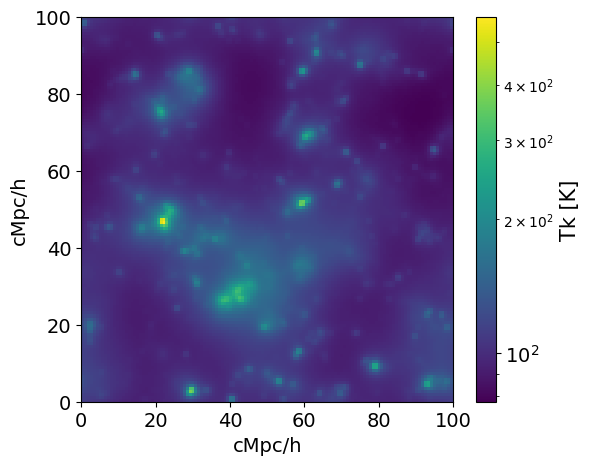

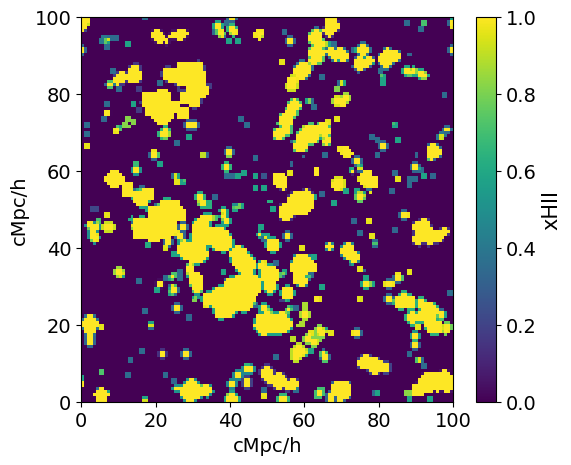

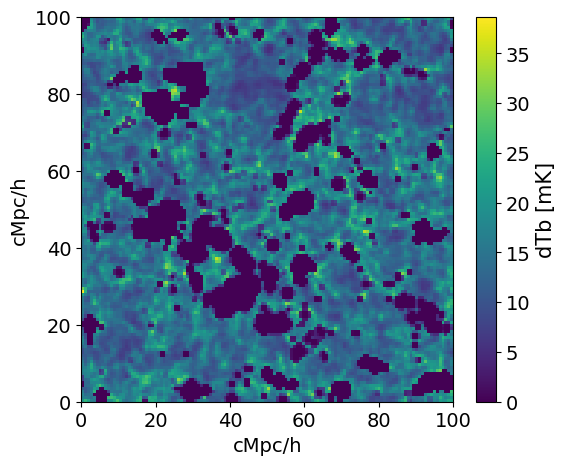

In [ ]:
from beorn.plotting import plot_2d_map
slice_nbr = 64
dTb_map   = beorn.load_grid(parameters, z=7.72, type='dTb')
T_map     = beorn.load_grid(parameters, z=7.72, type='Tk')
xHII_map  = beorn.load_grid(parameters, z=7.72, type='bubbles')
plot_2d_map(T_map, Lbox=Lbox, slice_nbr=slice_nbr, qty='Tk [K]',scale='log')
plot_2d_map(xHII_map, Lbox=Lbox, slice_nbr=slice_nbr, qty='xHII')
plot_2d_map(dTb_map, Lbox=Lbox, slice_nbr=slice_nbr, qty='dTb [mK]')


--BEORN -- plotting power spectrum of  xHII at redshift  7.715
--BEORN -- plotting power spectrum of  dTb at redshift  7.715
--BEORN -- plotting power spectrum of  T at redshift  7.715


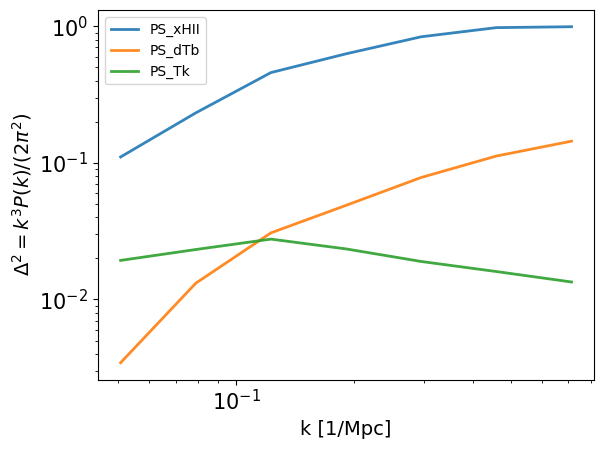

In [ ]:
z  = 7.72
PS = beorn.load_f('./physics/GS_PS_128_test.pkl')
plot_PS_Beorn(z, PS, color='C0', ax=plt, label='PS_xHII', qty='xHII',  ls='-', alpha=0.9, lw=2)
plot_PS_Beorn(z, PS, color='C1', ax=plt, label='PS_dTb', qty='dTb',  ls='-', alpha=0.9, lw=2)
plot_PS_Beorn(z, PS, color='C2', ax=plt, label='PS_Tk', qty='T',  ls='-', alpha=0.9, lw=2)

In [ ]:
# ##### Plot the results (dTb, Tk, xHII, PS_dTb(z))
# ##### Need more than 1 halo catalog.
# import matplotlib.pyplot as plt
# import matplotlib
# from beorn.plotting import plot_Beorn_PS_of_z
# import matplotlib.gridspec as gridspec
# matplotlib.rc('xtick', labelsize=15)
# matplotlib.rc('ytick', labelsize=15)
# fig = plt.figure(constrained_layout=True)
# fig.set_figwidth(18)

# fig.set_figheight(6)

# gs = gridspec.GridSpec(2, 3, figure=fig)

# ax1 = fig.add_subplot(gs[:,0])
# ax2 = fig.add_subplot(gs[0,1])
# ax3 = fig.add_subplot(gs[1,1],sharex=ax2)
# ax4 = fig.add_subplot(gs[:,2])
    
    

# GS_PS = beorn.load_f('./physics/GS_PS_' + str(param.sim.Ncell) + '_' + param.sim.model_name + '.pkl')
# GS_approx = beorn.load_f('./physics/GS_approx'+'_' + param.sim.model_name + '.pkl')

# ax1.plot(GS_PS['z'],GS_PS['dTb'],'*',lw=2,alpha=0.8,ls='-',color='gray',label='BEoRN')
# ax1.plot(GS_approx['z'],GS_approx['dTb'],ls='--',label='')
# ax1.legend(fontsize=15,loc='upper right')
# ax1.set_xlim(6,20)
# ax1.set_ylim(-62,13)
# ax1.set_xlabel('z',fontsize=15)
# ax1.set_ylabel('dTb [mK]',fontsize=15)



# ax2.plot(GS_PS['z'],GS_PS['Tk'],'*',lw=2,alpha=0.8,ls='-',color='gray',label='BEoRN')
# ax2.plot(GS_approx['z'],GS_approx['Tk'],ls='--',color='gray')
# ax2.semilogy([],[])
# ax2.set_ylim(3,5e2)
# ax2.set_ylabel('$T_{k}$ [K]',fontsize=17)
# #plt.show()


# ax3.plot(GS_PS['z'],GS_PS['x_HII'],'*',lw=2,alpha=0.8,ls='-',color='gray',label='BEoRN')
# ax3.plot(GS_approx['z'],GS_approx['x_HII'],ls='--',color='gray')
# ax3.set_xlim(6.3,15)
# ax3.set_ylabel('$x_{\mathrm{HII}}$',fontsize=17)
# ax3.set_xlabel('z ',fontsize=17)


# plot_Beorn_PS_of_z(0.1, GS_PS, GS_PS,ls='-',lw=1, color='b',RSD = False,label='',qty='dTb',alpha=1,ax=plt)


# ax4.plot([1e-1],[1e-2])

# ax4.set_ylim(1e-1,1e2)
# ax4.set_xlim(5.8,18)
# ax4.set_ylabel('$\Delta_{21}^{2}(k,z)$ [mK]$^{2}$ ',fontsize=18) # k^{3}P(k)/(2\pi^{2})
# ax4.set_xlabel('z ',fontsize=17)
# ax4.legend(loc='best',fontsize=15)

# ax2.axes.get_xaxis().set_visible(False)
# plt.show()